# Monte-Carlo sampling to quantify ECS

To implement Monte-Carlo sampling, [PyMC3](https://docs.pymc.io/)(Salvatier, Wiecki, and Fonnesbeck 2016) was used which takes care of initialization of the random distribution and random choice sampling in an elegant way. The definitions of the probability distributions are done symbolically to support lazy evaluation. It is also advantageous to use it, since it supports parallel processing by out of the box.

To model the equations to solve for ECS, the input parameters were initialized as normal distributions using the class ``pymc3.Normal``. Thereafter ECS was defined using the class ``pymc3.Deterministic``, since it has an algebraic relation with the input parameters. The library was

PyMC3 defaults to a random sampler known as the *No U-turn Sampler* or *NUTS* (Hoﬀman and Gelman, 2014) which was used to draw 100000 samples from each parameter iteratively and in parallel to compute ECS.

In [1]:
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns
from uncertainties import ufloat
sns.set(color_codes=True)


def normal_dist(quantity: ufloat, name: str):
    """Initializes and returns a normal distributiion."""
    return pm.Normal(
        name,
        mu=quantity.nominal_value,
        sd=quantity.std_dev,
    )

## Process-approach 

In [2]:
from util import forcing_co2, lambdas

with pm.Model() as model:
    df2x = normal_dist(forcing_co2, "$F_{2x}$")
    dlambda = [
        normal_dist(l, r"$\lambda:{}$".format(key))
        for key, l in lambdas.items()
    ]
    ECS = pm.Deterministic("ECS", -df2x / tt.sum(dlambda))

model

In [3]:
import os
with model:
    trace = pm.sample(
        100_000,
        cores=os.cpu_count() // 2
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [$\lambda:cloud$, $\lambda:albedo$, $\lambda:waterlapse$, $\lambda:planck$, $F_{2x}$]
Sampling 6 chains: 100%|██████████| 603000/603000 [06:44<00:00, 440.84draws/s]


### Save trace

In [50]:
import pickle
with open("trace_q1.pkl", "wb") as trace_pkl:
    pickle.dump(trace, trace_pkl)

### Load trace

In [3]:
import pickle
with open("trace_q1.pkl", "rb") as trace_pkl:
    trace = pickle.load(trace_pkl)

### Sampled values and their distributions

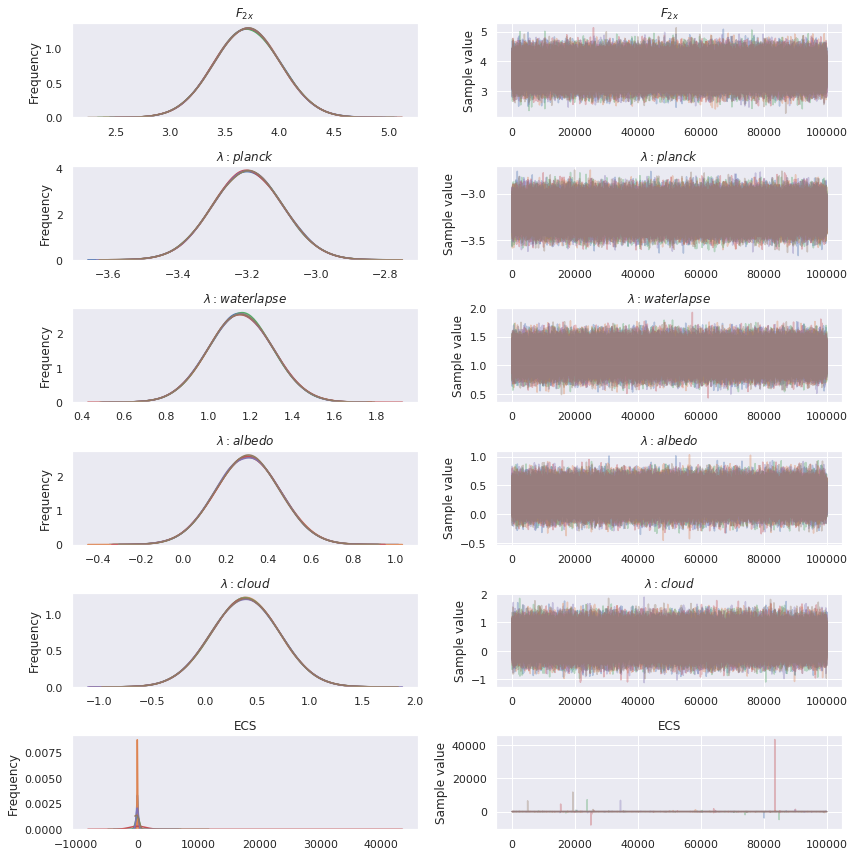

In [4]:
%%capture --no-display
%matplotlib inline
axes = pm.traceplot(trace)

GridSpec(1, 1)

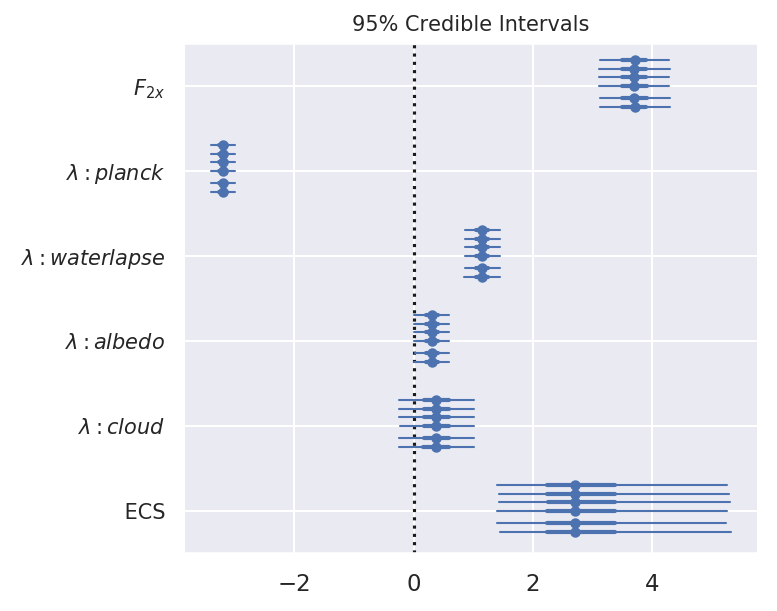

In [5]:
plt.figure(dpi=150)
pm.plots.forestplot(trace, rhat=False)

### Input parameters

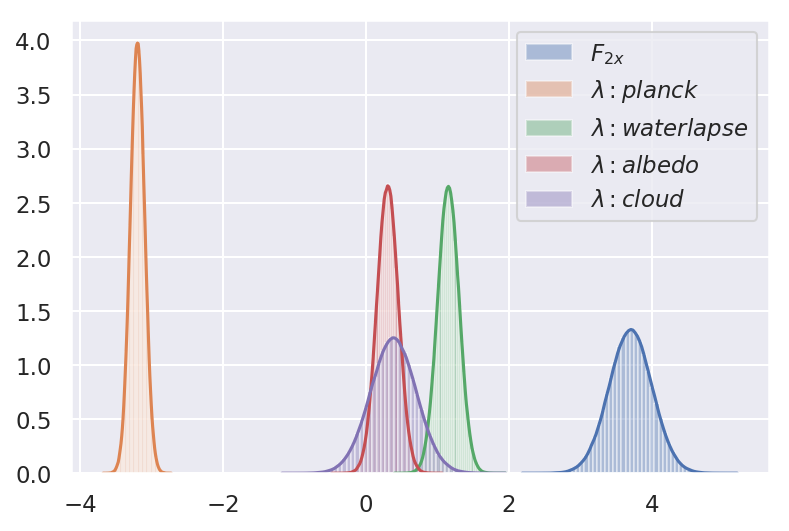

In [6]:
%%capture --no-display
%matplotlib inline

plt.figure(dpi=150)
for var in trace.varnames:
    value = trace.get_values(var)
    if var != "ECS":
        sns.distplot(value, label=var)

plt.legend()

### ECS

In [7]:
import numpy as np
ECS = trace.get_values('ECS')

np.median(ECS)

2.7015459720884865

(0, 6)

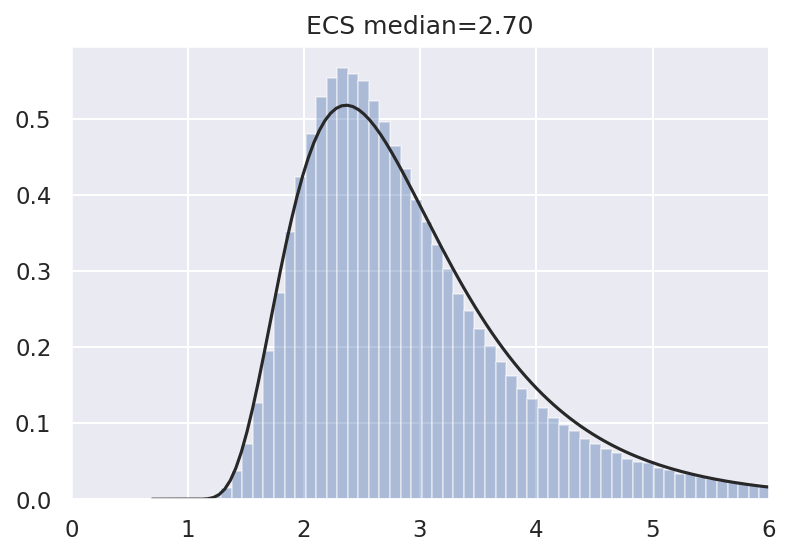

In [8]:
from scipy.stats import lognorm
from util import between

plt.figure(dpi=150)
cond = between(ECS, 0, 10)
sns.distplot(ECS[cond], bins=100, label="ECS", kde=False, fit=lognorm)
plt.title(f"ECS median={np.median(ECS[cond]):.2f}")
plt.xlim(0, 6)

## Historical warming

In [9]:
from util import forcing_co2, delta_temp, delta_forcing, N1, N2

with pm.Model() as model:
    df2x = normal_dist(forcing_co2, "$F_{2x}$")
    dDelta_T = normal_dist(delta_temp, "$\Delta T$")
    dDelta_F = normal_dist(delta_forcing, "$\Delta F$")
    dN1 = normal_dist(N1, "$N_1$")
    dN2 = normal_dist(N2, "$N_2$")
    dDelta_N = dN2 - dN1
    ECS = pm.Deterministic("ECS", (df2x*dDelta_T) / (dDelta_F - dDelta_N))

model

In [5]:
import os
with model:
    trace = pm.sample(
        100_000,
        cores=os.cpu_count() // 2
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [$N_2$, $N_1$, $\Delta F$, $\Delta T$, $F_{2x}$]
Sampling 6 chains: 100%|██████████| 603000/603000 [07:18<00:00, 1373.78draws/s]


### Save trace

In [6]:
import pickle
with open("trace_q2.pkl", "wb") as trace_pkl:
    pickle.dump(trace, trace_pkl)

### Load trace

In [10]:
import pickle
with open("trace_q2.pkl", "rb") as trace_pkl:
    trace = pickle.load(trace_pkl)

### Sampled values and their distributions

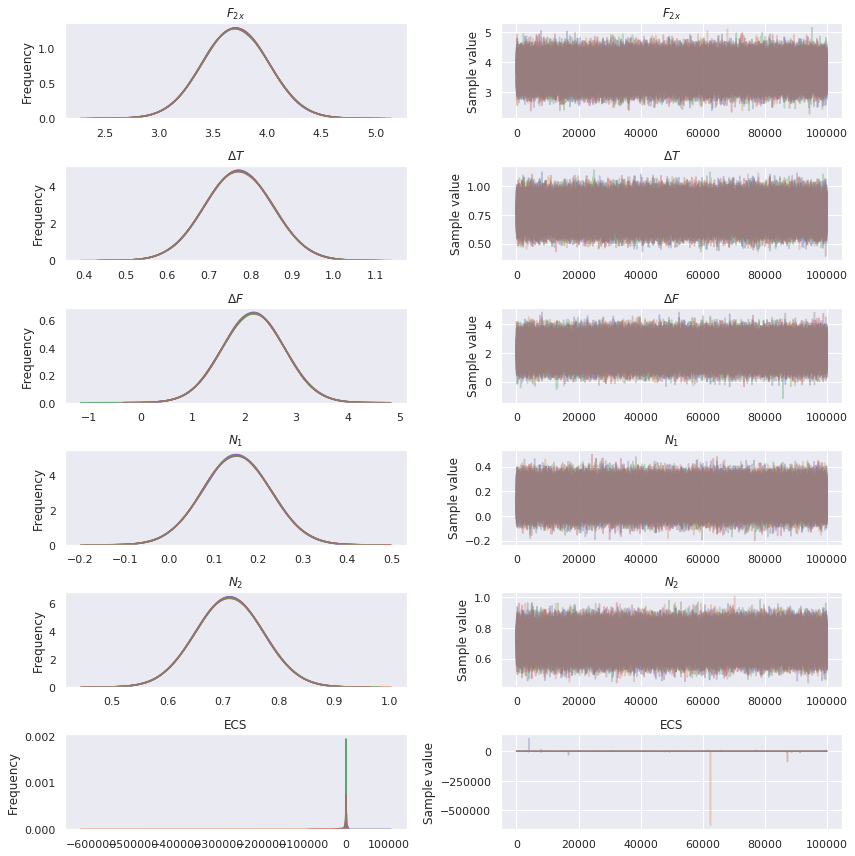

In [11]:
%%capture --no-display
%matplotlib inline
axes = pm.traceplot(trace)

GridSpec(1, 1)

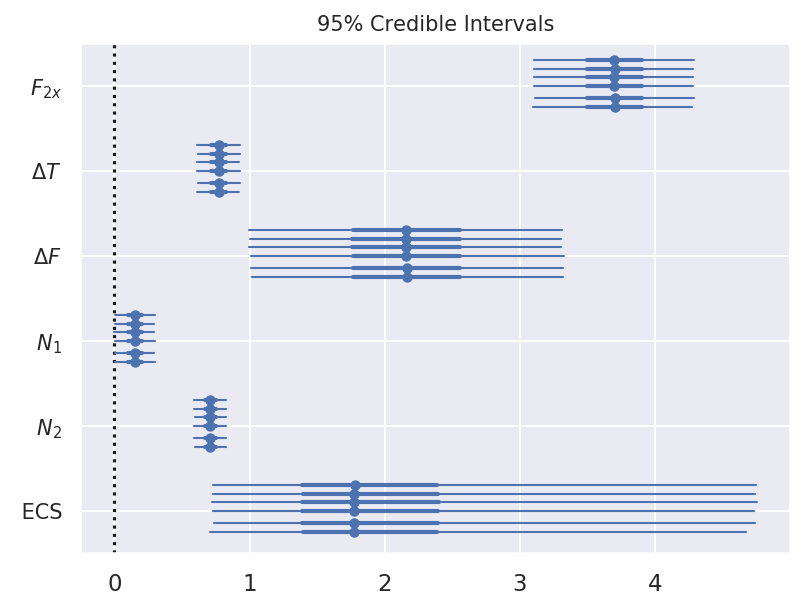

In [12]:
plt.figure(dpi=150)
pm.plots.forestplot(trace, rhat=False)

### Input parameters

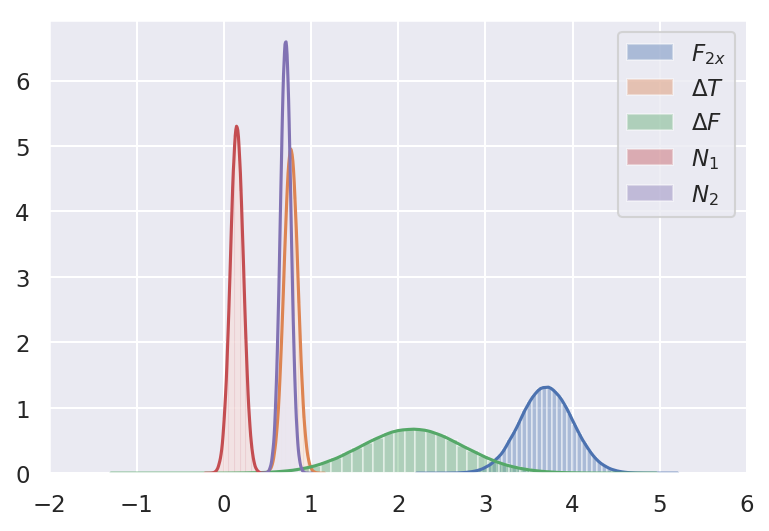

In [13]:
%%capture --no-display
%matplotlib inline

plt.figure(dpi=150)
for var in trace.varnames:
    value = trace.get_values(var)
    if var != "ECS":
        sns.distplot(value, label=var)

plt.xlim(-2, 6)
plt.legend()

### ECS

In [14]:
import numpy as np
ECS = trace.get_values('ECS')

np.median(ECS)

1.7734117656095303

(0, 10)

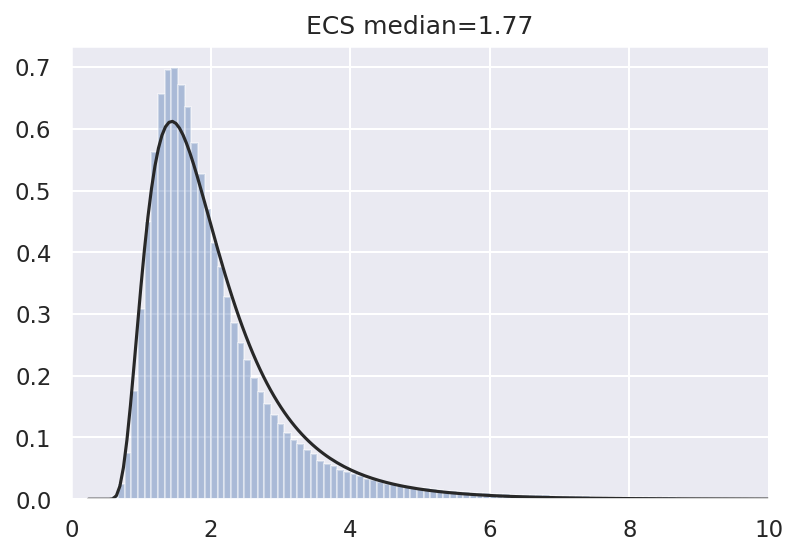

In [15]:
from scipy.stats import lognorm
from util import between

plt.figure(dpi=150)
cond = between(ECS, 0, 10)
sns.distplot(ECS[cond], bins=100, label="ECS", kde=False, fit=lognorm)
plt.title(f"ECS median={np.median(ECS[cond]):.2f}")
plt.xlim(0, 10)

## Bibliography

1. Salvatier, John, Thomas V. Wiecki, and Christopher Fonnesbeck. 2016. “Probabilistic Programming in Python Using PyMC3.” PeerJ Computer Science 2 (April): e55. https://doi.org/10.7717/peerj-cs.55.
2. Hoﬀman, Matthew D, and Andrew Gelman. n.d. “The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo,” 31.